In [2]:
from algorithm.utils.data.tf.dataimage import DataImage
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import keras
%load_ext tensorboard

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
normalize = True
mean = 'auto' # 'auto' -> mean_value = [float(1/255), float(1/255), float(1/255)]
mean_value = [float(1/255), float(1/255), float(1/255)]

In [4]:
dataset = DataImage(data_path="../Input/dataset", split='train only', resize=True, height='auto', width='auto', normalize=normalize, mean=mean, name="Electronic components dataset", batch_size=16)

In [5]:
dataset

Electronic components dataset
	Number of points: 2884
	Root location: ../Input/dataset
	Split: 0
	Transform used:	Resize(size=(128, 128)
	Normalize(mean=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098], std=None)


In [6]:
trainset = dataset.get_set(split="train")

In [7]:
# get some random training images
dataiter = iter(trainset)
images, labels = next(dataiter)

In [8]:
images

{'data': <tf.Tensor: shape=(16, 128, 128, 3), dtype=float32, numpy=
 array([[[[0.9960785 , 0.9960785 , 0.9960785 ],
          [0.9960785 , 0.9960785 , 0.9960785 ],
          [0.9960785 , 0.9960785 , 0.9960785 ],
          ...,
          [0.98030007, 0.98048437, 0.9803922 ],
          [0.97232527, 0.98845917, 0.9843138 ],
          [0.97170657, 0.98907787, 0.9843138 ]],
 
         [[0.9960785 , 0.9960785 , 0.9960785 ],
          [0.9960785 , 0.9960785 , 0.9960785 ],
          [0.9960785 , 0.9960785 , 0.9960785 ],
          ...,
          [0.9794104 , 0.98082113, 0.9803922 ],
          [0.9455016 , 0.989277  , 0.97394305],
          [0.93890935, 0.9921569 , 0.97394305]],
 
         [[0.9960785 , 0.9960785 , 0.9960785 ],
          [0.9960785 , 0.9960785 , 0.9960785 ],
          [0.9960785 , 0.9960785 , 0.9960785 ],
          ...,
          [0.9956496 , 0.9965074 , 0.9960785 ],
          [0.94885117, 0.9925253 , 0.97705275],
          [0.94597125, 0.992739  , 0.97705275]],
 
         ...,


In [9]:
labels

<tf.Tensor: shape=(16,), dtype=string, numpy=
array([b'Not mounted', b'Not mounted', b'Resistor', b'Not mounted',
       b'Ceramic capacitor', b'Rectangular pin', b'Resistor',
       b'Tantalum capacitor', b'Resistor', b'Resistor', b'Resistor',
       b'Ceramic capacitor', b'Not mounted', b'Ceramic capacitor', b'LED',
       b'Not mounted'], dtype=object)>

In [10]:
class_names = dataset.labels

In [11]:
class_names

['Ceramic capacitor',
 'Connector',
 'Diode',
 'Dip Switch',
 'Fuse',
 'IC',
 'Inductor',
 'Jumper',
 'Jumper cut',
 'LED',
 'Minimelf',
 'Not mounted',
 'Optoisolator',
 'Oscillator',
 'Pushbutton',
 'Rectangular pin',
 'Relais',
 'Resistor',
 'Resistor Network',
 'SOT',
 'TO252',
 'Tantalum capacitor']

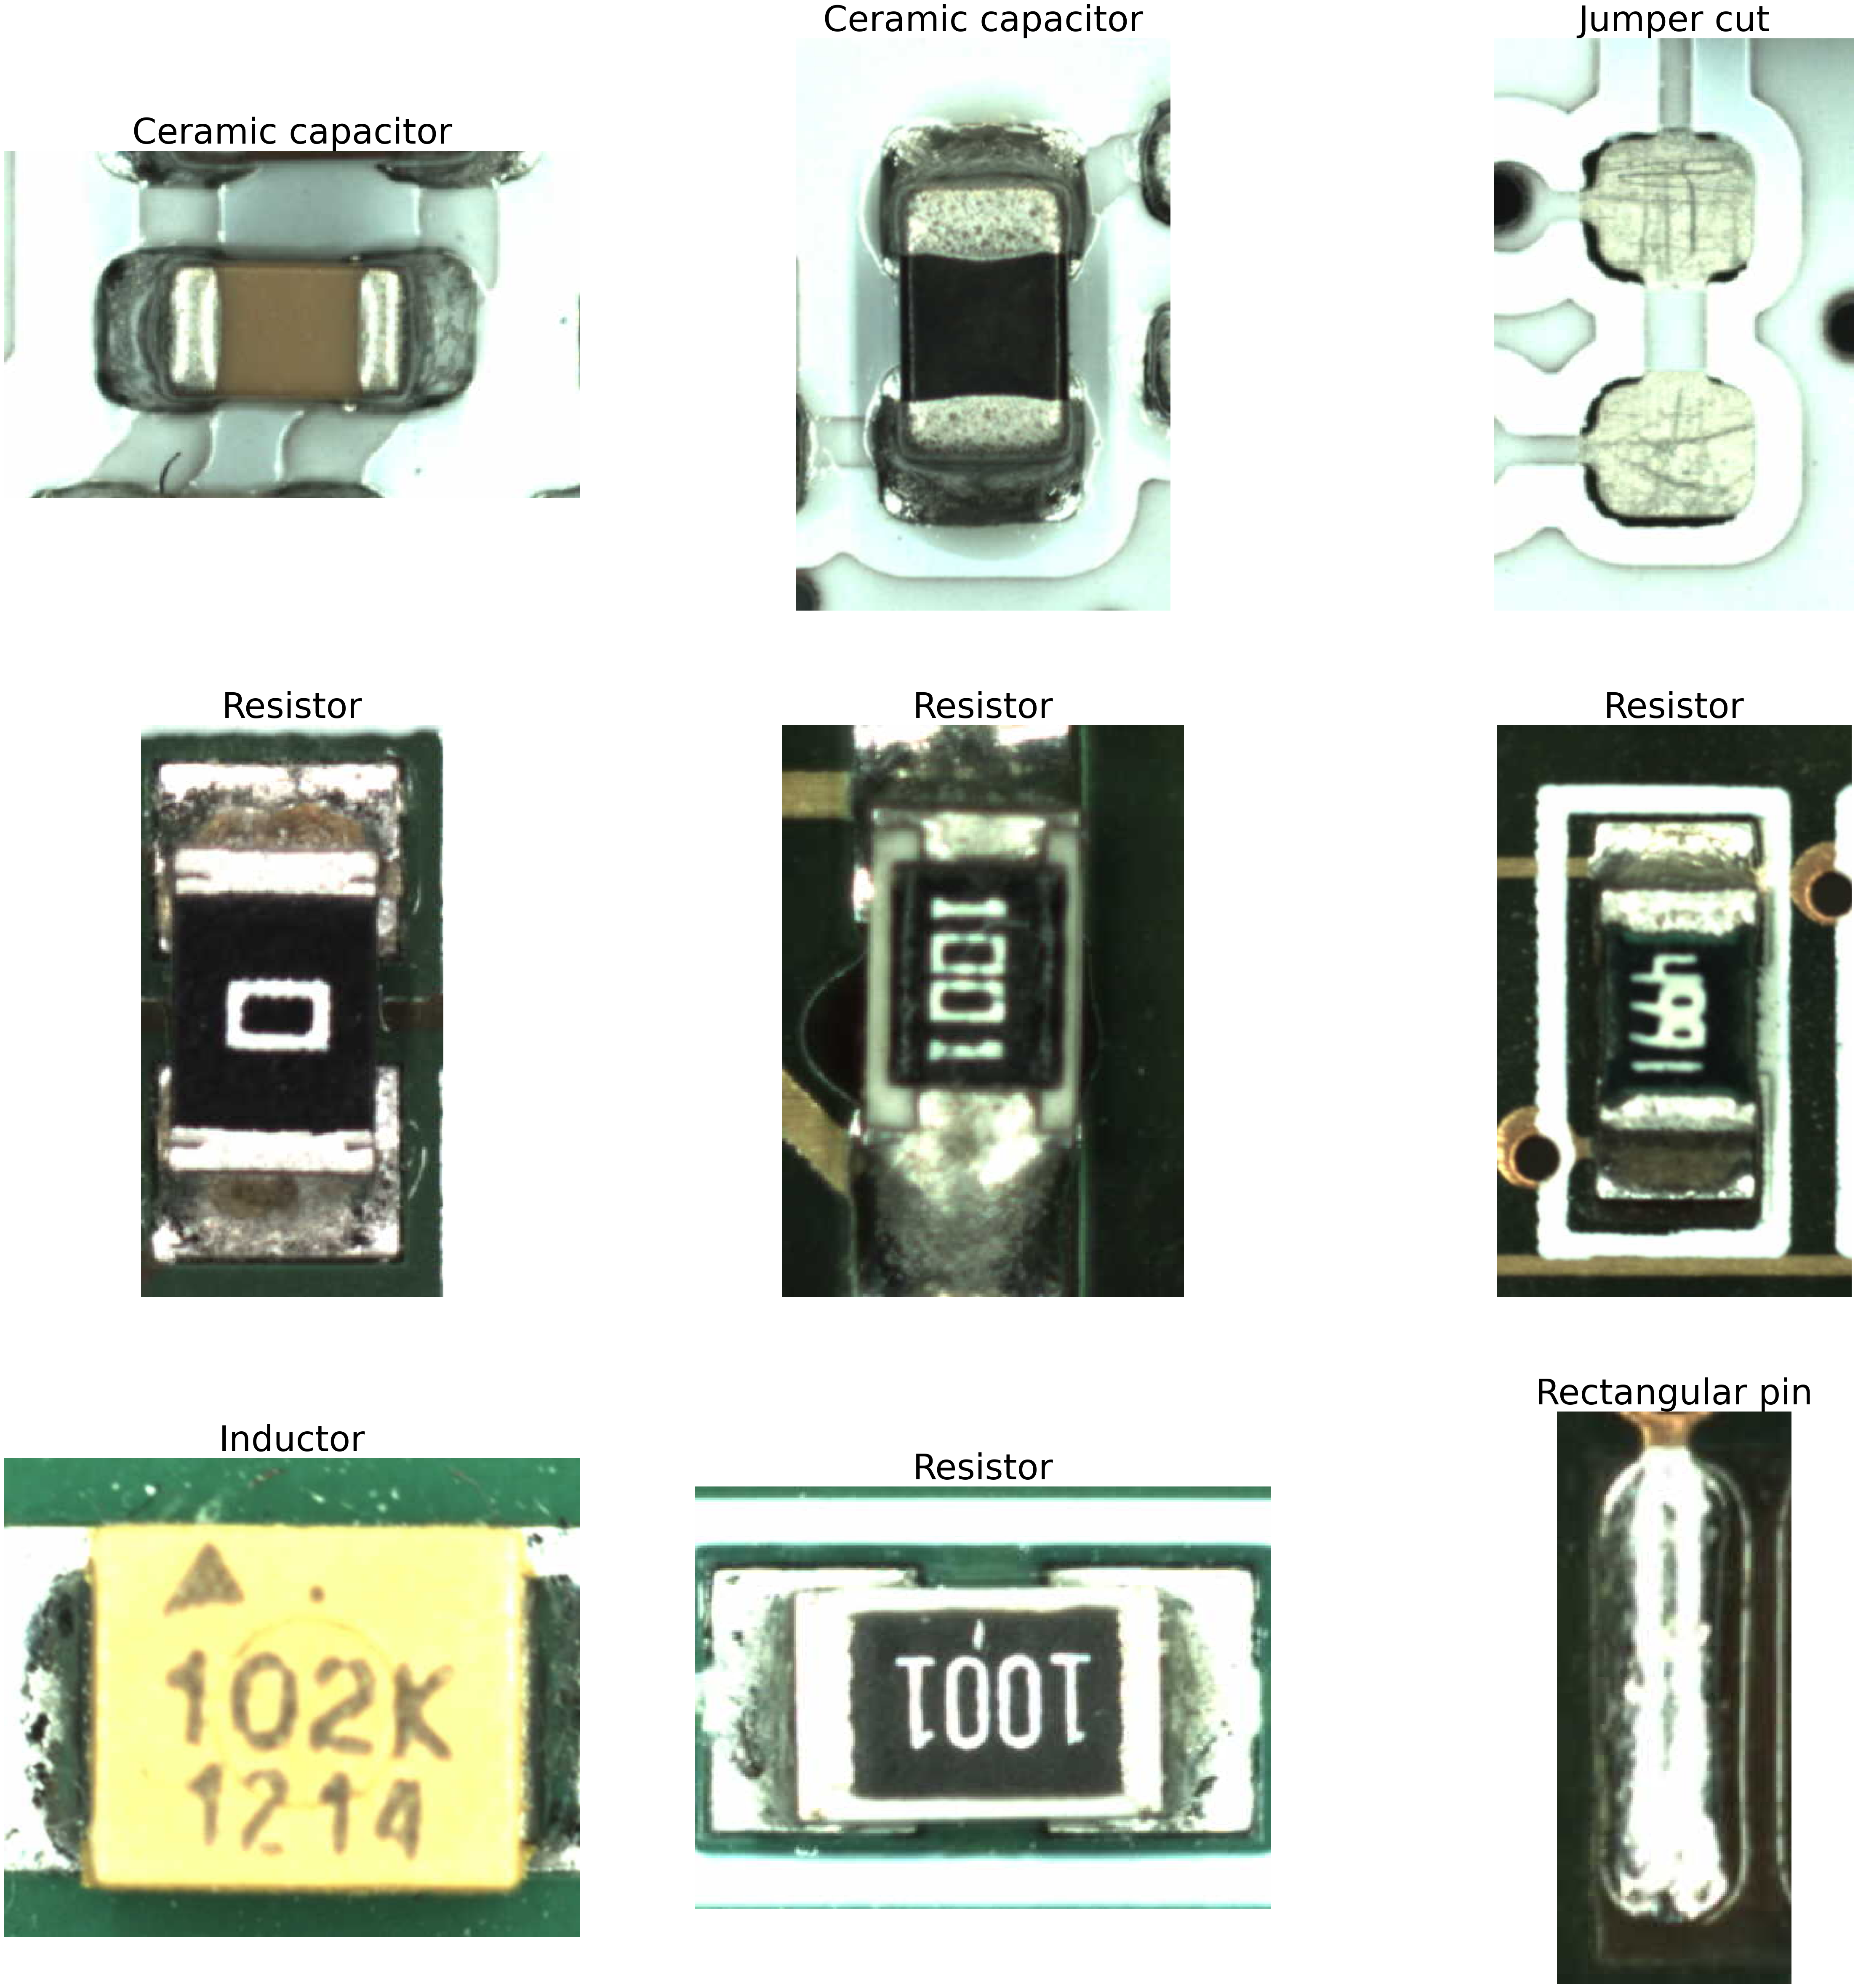

In [12]:
import matplotlib.pyplot as plt
import numpy as np
image_batch, label_batch = next(iter(trainset))

plt.figure(figsize=(60, 60))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    printable_object = dataset.print_item(image_batch['print_object'][i])
    plt.imshow(printable_object)
    label = label_batch[i].numpy().decode("utf-8")
    plt.title(label, fontsize=60)
    plt.axis("off")

In [13]:
from algorithm.deep.tf.neural_networks import ResNet2__0

In [14]:
trainset = dataset.apply_one_hot_encoding(trainset)

In [15]:
out_dir = "../out/models/ResNet2__0_3"

In [16]:
model = ResNet2__0(len(class_names),input_shape=(128, 128, 3), field='data')

In [17]:
import warnings

class EarlyStoppingOnTarget(keras.callbacks.Callback):
    def __init__(self, monitor='accuracy', target=1.0, tensorboard_callback=None):
        super(EarlyStoppingOnTarget, self).__init__()
        self.monitor = monitor
        self.target = target
        self.tensorboard_callback = tensorboard_callback
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn(f"Early stopping requires {self.monitor} available!", RuntimeWarning)
        if current is not None and current >= self.target:
            print(f"\n{self.monitor} target reached ({self.target}). Training stopped.")
            self.model.stop_training = True
        #if self.tensorboard_callback is not None:
        #self.tensorboard_callback.on_epoch_end(epoch, logs)

tb_callback = keras.callbacks.TensorBoard(log_dir=f'{out_dir}/tensorboard_log', histogram_freq=1)
es_callback = EarlyStoppingOnTarget(target=1.0, tensorboard_callback=tb_callback)

In [18]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.categorical_crossentropy,
    metrics=["accuracy"],
    run_eagerly=True,
)

In [19]:
tf.get_logger().setLevel('ERROR')

model.fit(trainset, epochs=1000, callbacks=[tb_callback, es_callback])

Epoch 1/1000
181/181 [==============================] - 149s 645ms/step - loss: 3.3599 - accuracy: 0.7340
Epoch 2/1000
181/181 [==============================] - 109s 600ms/step - loss: 0.4330 - accuracy: 0.8904
Epoch 3/1000
181/181 [==============================] - 108s 596ms/step - loss: 0.1995 - accuracy: 0.9459
Epoch 4/1000
181/181 [==============================] - 108s 597ms/step - loss: 0.2157 - accuracy: 0.9570
Epoch 5/1000
181/181 [==============================] - 107s 590ms/step - loss: 0.9511 - accuracy: 0.8121
Epoch 6/1000
181/181 [==============================] - 110s 604ms/step - loss: 0.3629 - accuracy: 0.9105
Epoch 7/1000
181/181 [==============================] - 109s 598ms/step - loss: 0.1973 - accuracy: 0.9490
Epoch 8/1000
181/181 [==============================] - 106s 587ms/step - loss: 0.1472 - accuracy: 0.9667
Epoch 9/1000
181/181 [==============================] - 105s 581ms/step - loss: 0.1604 - accuracy: 0.9584
Epoch 10/1000
181/181 [=======================

In [20]:
model.summary()

Model: "res_net2__0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 4, 4, 2048)        58370944  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1000)              32769000  
                                                                 
 dense_1 (Dense)             (None, 22)                22022     
                                                                 
 model (Functional)          (None, 22)                91161966  
                                                                 
Total params: 91161966 (347.76 MB)
Trainable params: 91010542 (347.18 MB)
Non-trainable params: 151424 (591.50 KB)
_________________________________________________________________


In [21]:
model.save(out_dir)

In [ ]:
keras.utils.plot_model(model, f'{out_dir}/ResNet2__1_3.svg', show_shapes=True, show_layer_activations=True, show_layer_names=True)